In [1]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io
from process_data_rnn_ssm import min_max_scaler,sliding_window
from sklearn import preprocessing
plt.rcParams.update({'font.size': 22})
import os, os.path
import pandas as pd
plt.rcParams["figure.figsize"] = (20,10)
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler
plt.rcParams.update({'font.size': 22})
from scipy import signal
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)
import mne
from mne.viz import plot_topomap
import pickle
from eeg_config import Config
from train_VRNN import decode_z


In [2]:
def scale_back(data,scalers):
    unscaled_data = np.zeros(data.shape)
    for i,row in enumerate(data):
        #print(i)
        row = row.reshape((1,int(row.shape[0]*row.shape[1])))
        unscaled_row = scalers[i].inverse_transform(row)
        unscaled_row = unscaled_row.reshape((768,64))
        unscaled_data[i] = unscaled_row
    return unscaled_data

def get_trial_per_participant(data,trials_per_participant):
    mean_per_p = np.zeros((19,768,64))
    for i, n in enumerate(trials_per_participant):
        prev = int(np.sum(trials_per_participant[0:i]))
        if n != 0:
            for j in range(int(n)):
                mean_per_p[i] +=data[j+prev]
            mean_per_p[i]/n
    return mean_per_p

In [3]:
mat = scipy.io.loadmat('iravani_neuro_data/SL07_02/eeg_data_session_01.mat')
trials = mat['data_eeg'][0][0][4][1][0][0]
ch_names = []
for arr in mat['data_eeg'][0][0][4]:
    ch_names.append(arr[0][0])
print(ch_names[0])

n_channels = 64
sampling_freq = 128  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

#ch_names = [f'MEG{n:03}' for n in range(1, 10)] + ['EOG001']
ch_names = ch_names[0:64]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
print(info)
info.set_montage('biosemi64')

Fp1
<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 64 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 128.0 Hz
>
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 128.0 Hz
>


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 128.0 Hz
>

In [170]:
def pre_process_trial(trial,cols,w):
    trial = trial[0:64]
    #trial = trial[66:70]
    #print(trial.shape)
    #plt.plot(trial[1])
    #trial = trial.reshape((1536,cols))
    trial = trial.T
    #plt.plot(trial[:,1])
    #trial = gaussian_filter1d(trial,2.8)
    #trial = trial[100:-100]
    
    trial = trial[1::2]
    trial = trial.reshape((49152,1))
    #trial = trial.reshape((3072,1))
    scaler = MinMaxScaler()
    scaler.fit(trial)
    trial = scaler.transform(trial)
    trial = trial.reshape((768,cols))
    trial = sliding_window(trial,w=w)
    
    return trial,scaler

def extract_experiment(path,exp_name,cols,w,train_data,train_labels,dis_data,n_dis,count_diff_dis,dis_min_max_scalers,ple_data,n_ple,count_diff_ple,ple_min_max_scalers,neu_data,n_neu,count_diff_neu,neu_min_max_scalers):
    full_path= path+"/"+exp_name
    #print(full_path)
    mat = scipy.io.loadmat(full_path)
    bias = 0
    trials = mat['data_eeg'][0][0][1][0]
    odours = mat['data_eeg'][0][0][5]
    if j == 0:
        bias = 0
    elif j == 1:
        bias = len(df[df.Chunks == 1])
    elif j == 2:
        bias = len(df[df.Chunks == 1]) + len(df[df.Chunks == 2])
    #print(trials.shape)
    for k,trial in enumerate(trials):
        #trial = np.append(trial[4:7],trial[39:42],axis=0)
        #trial = np.append(trial[0:64],trial[66:70],axis=0)
        #trial = trial.reshape((1,w,cols))
        #print("k",k)
        #print(bias)
        #print(k)
        #print(df.iloc[bias+k].Pleasantness)
        if df.iloc[bias+k].Pleasantness <30:
            trial,scaler = pre_process_trial(trial, cols, w)
            #print(trial)
            dis_min_max_scalers.append(scaler)
            n_dis +=1
            labs = np.zeros(trial.shape[0])
            dis_data = np.append(dis_data,trial,axis=0)
            train_labels = np.append(train_labels,labs)
            train_data = np.append(train_data,trial,axis=0)
            count_diff_dis[odours[k]] +=1

        elif df.iloc[bias+k].Pleasantness > 77:
            trial,scaler = pre_process_trial(trial, cols, w)
            ple_min_max_scalers.append(scaler)
            n_ple +=1
            labs = np.ones(trial.shape[0])
            ple_data = np.append(ple_data,trial,axis=0)
            train_labels = np.append(train_labels,labs)
            train_data = np.append(train_data,trial,axis=0)
            count_diff_ple[odours[k]] +=1
        
        elif df.iloc[bias+k].Pleasantness > 48 and df.iloc[bias+k].Pleasantness < 52:
            trial,scaler = pre_process_trial(trial, cols, w)
            neu_min_max_scalers.append(scaler)
            n_neu +=1
            neu_data = np.append(neu_data,trial,axis=0)
            count_diff_neu[odours[k]] +=1
            
    return train_data,train_labels,dis_data,n_dis,count_diff_dis,dis_min_max_scalers,ple_data,n_ple,count_diff_ple,ple_min_max_scalers,neu_data,n_neu,count_diff_neu,neu_min_max_scalers
    

In [171]:
ground_path='/Users/corytrevor/Documents/Skola/KTH/EE/Master/exjobb/Code/VRNNC/src/iravani_neuro_data/'
dir_names = [name for name in os.listdir(ground_path) if name.startswith('SL') ]
print(dir_names)
dir_names.sort()
ind = 0
cols = 64
w = 768
train_labels = np.zeros(1)
train_data = np.zeros((1,w,cols))
ple_data = np.zeros((1,w,cols))
dis_data = np.zeros((1,w,cols))
neu_data = np.zeros((1,w,cols))
test_labels = np.zeros(1)
test_data = np.zeros((1,w,cols))
ple_test_data = np.zeros((1,w,cols))
dis_test_data = np.zeros((1,w,cols))
neu_test_data = np.zeros((1,w,cols))
trials_per_participant_ple = np.zeros(19)
trials_per_participant_dis = np.zeros(19)
trials_per_participant_neu = np.zeros(19)
count_diff_ple = np.zeros(33)
count_diff_dis = np.zeros(33)
count_diff_neu = np.zeros(33)
trials_per_participant_ple_test = np.zeros(19)
trials_per_participant_dis_test = np.zeros(19)
trials_per_participant_neu_test = np.zeros(19)
count_diff_ple_test = np.zeros(33)
count_diff_dis_test = np.zeros(33)
count_diff_neu_test = np.zeros(33)
train_ple_min_max_scalers = []
train_dis_min_max_scalers = []
train_neu_min_max_scalers = []
test_ple_min_max_scalers = []
test_dis_min_max_scalers = []
test_neu_min_max_scalers = []
for i, dir_name in enumerate(dir_names):
    #print(i)
    path = ground_path+dir_name
    exp_names = os.listdir(path)
    exp_names.sort()
    #print(exp_names)
    df = pd.read_csv("iravani_neuro_data/table_"+str(i+1)+".csv")
    #print("i",i)
    n_ple = 0
    n_dis = 0
    n_neu = 0
    n_ple_test = 0
    n_dis_test = 0
    n_neu_test = 0
    #exp_scalers = []
    for j, exp_name in enumerate(exp_names):
        #print(j)
        if j < 1 or j >1:
            train_data,train_labels,dis_data,n_dis,count_diff_dis,train_dis_min_max_scalers,ple_data,n_ple,count_diff_ple,train_ple_min_max_scalers,neu_data,n_neu,count_diff_neu,train_neu_min_max_scalers = extract_experiment(path,exp_name,cols,w,train_data,train_labels,dis_data,n_dis,count_diff_dis,train_dis_min_max_scalers,ple_data,n_ple,count_diff_ple,train_ple_min_max_scalers,neu_data,n_neu,count_diff_neu,train_neu_min_max_scalers)
            
            #exp_scalers.append(trial_scalers)

        else:
            test_data,test_labels,dis_test_data,n_dis_test,count_diff_dis_test,test_dis_min_max_scalers,ple_test_data,n_ple_test,count_diff_ple_test,test_ple_min_max_scalers,neu_test_data,n_neu_test,count_diff_neu_test,test_neu_min_max_scalers = extract_experiment(path,exp_name,cols,w,test_data,test_labels,dis_test_data,n_dis_test,count_diff_dis_test,test_dis_min_max_scalers,ple_test_data,n_ple_test,count_diff_ple_test,test_ple_min_max_scalers,neu_test_data,n_neu_test,count_diff_neu_test,test_neu_min_max_scalers)
    trials_per_participant_neu[i] = n_neu
    trials_per_participant_ple[i] = n_ple
    trials_per_participant_dis[i] = n_dis
    trials_per_participant_neu_test[i] = n_neu_test
    trials_per_participant_ple_test[i] =n_ple_test
    trials_per_participant_dis_test[i] =n_dis_test
    
train_data = train_data[1:]
train_labels = train_labels[1:]
ple_data = ple_data[1:]
dis_data = dis_data[1:]
neu_data = neu_data[1:]
test_data = test_data[1:]
test_labels = test_labels[1:]
ple_test_data = ple_test_data[1:]
dis_test_data = dis_test_data[1:]
neu_test_data = neu_test_data[1:]

['SL07_09', 'SL07_07', 'SL07_06', 'SL07_08', 'SL07_15', 'SL07_12', 'SL07_23', 'SL07_25', 'SL07_03', 'SL07_04', 'SL07_02', 'SL07_16', 'SL07_20', 'SL07_18', 'SL07_27', 'SL07_26', 'SL07_21', 'SL07_28', 'SL07_10']


[  0.  49.  52.   0.  99.   0.   0.   0.  82.   0.   0.   0.   0.   0.
   0.   0. 107.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  16.]
[49.0, 52.0, 99.0, 82.0, 107.0, 16.0]


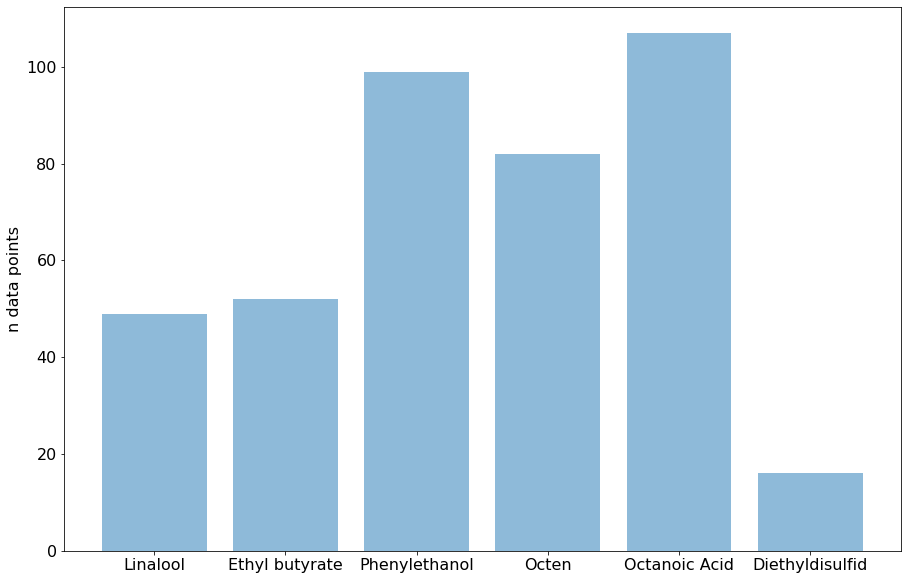

In [104]:
print(count_diff_neu)
arr = [count_diff_neu[1],count_diff_neu[2],count_diff_neu[4],count_diff_neu[8],count_diff_neu[16],count_diff_neu[32]]
print(arr)
plt.rcParams.update({'font.size': 16})
plt.figure(1)
plt.bar(np.arange(len(arr)), arr, align='center', alpha=0.5)

#plt.hist(arr, density=True, bins=6)
plt.ylabel('n data points')
plt.xticks(np.arange(len(arr)), ['Linalool','Ethyl butyrate','Phenylethanol','Octen','Octanoic Acid','Diethyldisulfid'])
#plt.xlabel("Odour");
plt.savefig("odour_distribution_neu.png")

In [167]:
print(ple_test_data.shape)
print(dis_data.shape)
print(neu_data.shape)
print(trials_per_participant_ple)

(31, 768, 64)
(107, 768, 64)
(405, 768, 64)
[41.  0.  0.  0.  1.  0.  2.  2.  0.  0.  0.  8.  8.  2.  1.  0. 34.  0.
  1.]


In [164]:
print(ple_data.shape)
print(dis_data.shape)

(100, 768, 64)
(107, 768, 64)


In [145]:
with open('neu_data_256.npy', 'wb') as f:
    np.save(f,neu_data)
    
with open('neu_test_data_256.npy', 'wb') as f:
    np.save(f,neu_test_data)

In [173]:
#train data
us_neu_data = scale_back(neu_data,train_neu_min_max_scalers)
trials_neu = trials_per_participant_neu
us_dis_data = scale_back(dis_data,train_dis_min_max_scalers)
trials_dis = trials_per_participant_dis

us_ple_data = scale_back(ple_data,train_ple_min_max_scalers)
trials_ple = trials_per_participant_ple
print(trials_per_participant_dis)

[28. 25. 11.  1.  9.  5.  7.  2.  3. 33. 19. 20. 23.  8. 17. 15. 16. 19.
 31.]


In [150]:
#synt train data
neu_synt_data = np.load("synt_neu_data_4.npy")
dis_synt_data = np.load("synt_dis_data_4_100.npy")
ple_synt_data = np.load("synt_ple_data_4_100.npy")
us_neu_data = scale_back(neu_synt_data,train_neu_min_max_scalers)
trials_neu = trials_per_participant_neu
us_dis_data = scale_back(dis_synt_data,train_dis_min_max_scalers)
trials_dis = trials_per_participant_dis

us_ple_data = scale_back(ple_synt_data,train_ple_min_max_scalers)
trials_ple = trials_per_participant_ple

In [132]:
#test data
us_neu_data = scale_back(neu_test_data,test_neu_min_max_scalers)
trials_neu = trials_per_participant_neu_test
us_dis_data = scale_back(dis_test_data,test_dis_min_max_scalers)
trials_dis = trials_per_participant_dis_test

us_ple_data = scale_back(ple_test_data,test_ple_min_max_scalers)
trials_ple = trials_per_participant_ple_test
print(trials_per_participant_dis)

[28. 25. 11.  1.  9.  5.  7.  2.  3. 33. 19. 20. 23.  8. 17. 15. 16. 19.
 31.]


In [133]:
def calc_alpha_per_participant(data,trials_per_participant,filter_,f_s=256):
    mean_per_p_f3 = np.zeros((19,385))
    mean_per_p_f4 = np.zeros((19,385))
    for i, n in enumerate(trials_per_participant):
        prev = int(np.sum(trials_per_participant[0:i]))
        if n != 0:
            for j in range(int(n)):
                sig = data[j+prev,:,4]
                sig_2 = data[j+prev,:,39]
                
                #filtrated with bandpass filter at 3–30 Hz. EEG signal
                sos = filter_
                filtered_f3 = signal.sosfilt(sos, sig)
                filtered_f4 = signal.sosfilt(sos, sig_2)
                
                #The power spectrum (μV2/Hz) of all segments was calculated using the Fast Fourier transformation and averaged for each condition.
                f, pxx_f3 = signal.periodogram(filtered_f3, f_s)
                #plt.semilogy(f[1:-1], pxx_f3[1:-1])

                f, pxx_f4 = signal.periodogram(filtered_f4, f_s)
                #plt.semilogy(f[1:-1], pxx_f4[1:-1])
                
                if abs(np.max(filtered_f3)) < 80 and abs(np.max(filtered_f4)) <80:
                    mean_per_p_f3[i] +=pxx_f3
                    mean_per_p_f4[i] +=pxx_f4
                    f_saved = f
                else:
                    n-=1
                    
            mean_per_p_f3[i]/n
    return mean_per_p_f3, mean_per_p_f4,f_saved

[24]
[90]


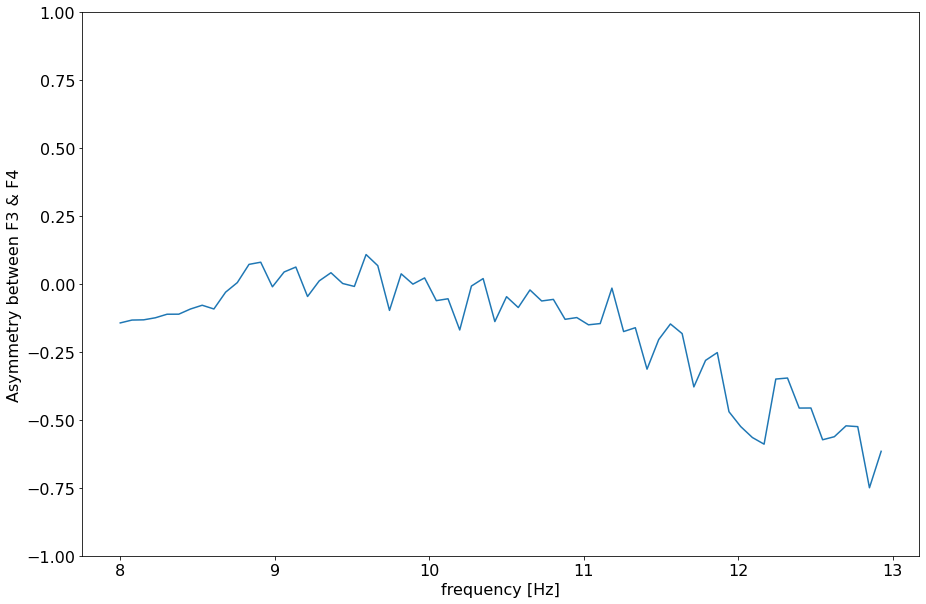

In [155]:
filter_ = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')

mean_f3, mean_f4,f = calc_alpha_per_participant(us_dis_data,trials_dis,filter_)
total_mean_f3_dis = np.mean(mean_f3,axis=0)
total_mean_f4_dis = np.mean(mean_f4,axis=0)

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = total_mean_f3_dis[start:stop]
sub_f4 = total_mean_f4_dis[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
plt.ylim(-1,1)
plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")
#plt.savefig("asymmetry_dis")


[24]
[90]


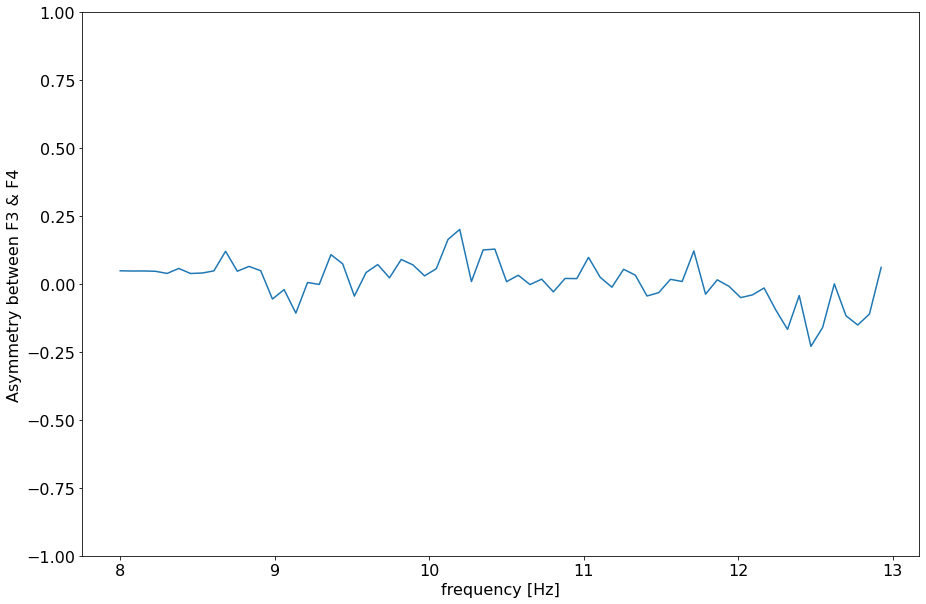

In [156]:
filter_ = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')

mean_f3, mean_f4,f = calc_alpha_per_participant(us_neu_data,trials_neu,filter_)
total_mean_f3_neu = np.mean(mean_f3,axis=0)
total_mean_f4_neu = np.mean(mean_f4,axis=0)

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = total_mean_f3_neu[start:stop]
sub_f4 = total_mean_f4_neu[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
plt.ylim(-1,1)
plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")
#plt.savefig("asymmetry_neutral")

[24]
[90]
[24]
[90]


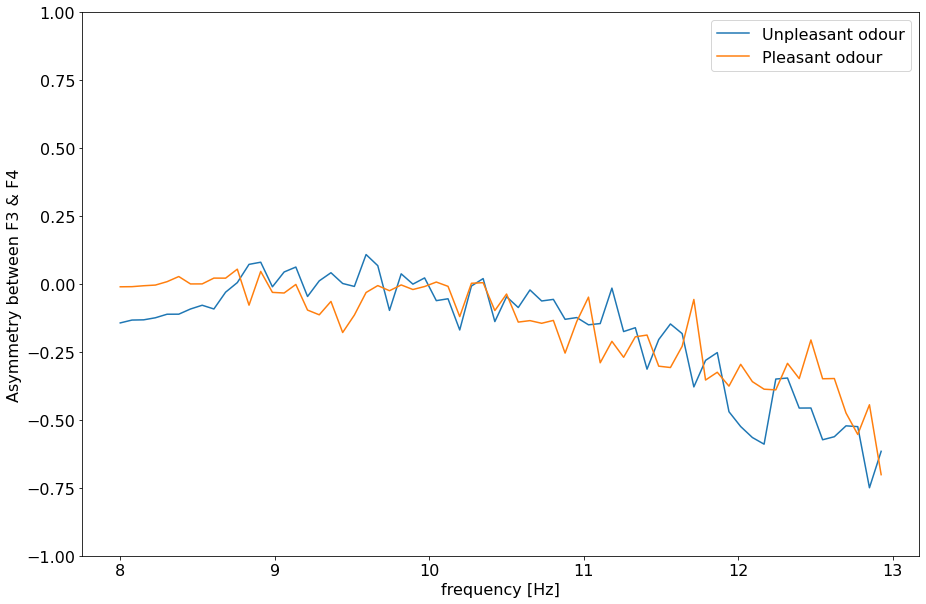

In [174]:
filter_ = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')

mean_f3, mean_f4,f = calc_alpha_per_participant(us_dis_data,trials_dis,filter_)
total_mean_f3_dis = np.mean(mean_f3,axis=0)
total_mean_f4_dis = np.mean(mean_f4,axis=0)

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = total_mean_f3_dis[start:stop]
sub_f4 = total_mean_f4_dis[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
plt.ylim(-1,1)
plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")

filter_ = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')

mean_f3, mean_f4,f = calc_alpha_per_participant(us_ple_data,trials_ple,filter_)
total_mean_f3_ple = np.mean(mean_f3,axis=0)
total_mean_f4_ple = np.mean(mean_f4,axis=0)

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = total_mean_f3_ple[start:stop]
sub_f4 = total_mean_f4_ple[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
#plt.ylim(-4,7)
plt.ylim(-1,1)

plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")
plt.legend(["Unpleasant odour", "Pleasant odour"])

plt.savefig("asym_orig")


292.0
(292, 768, 64)
405.0
(405, 768, 64)


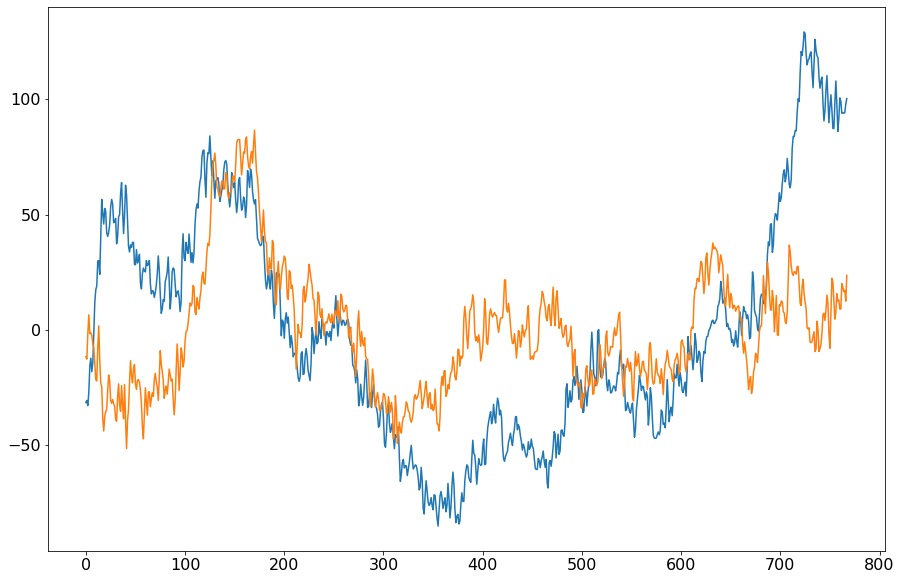

In [113]:
filter_ = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')


print(np.sum(trials_dis))
print(us_dis_data.shape)
mean_dis = get_trial_per_participant(us_dis_data,trials_dis)
total_mean_dis = np.mean(mean_dis,axis=0)
plt.plot(total_mean_dis[:,1])
print(np.sum(trials_neu))
print(us_neu_data.shape)

mean_neu = get_trial_per_participant(us_neu_data,trials_neu)

total_mean_neu = np.mean(mean_neu,axis=0)
plt.plot(total_mean_neu[:,1])

11.23720808891391
9.539289691780157
[24]
[90]


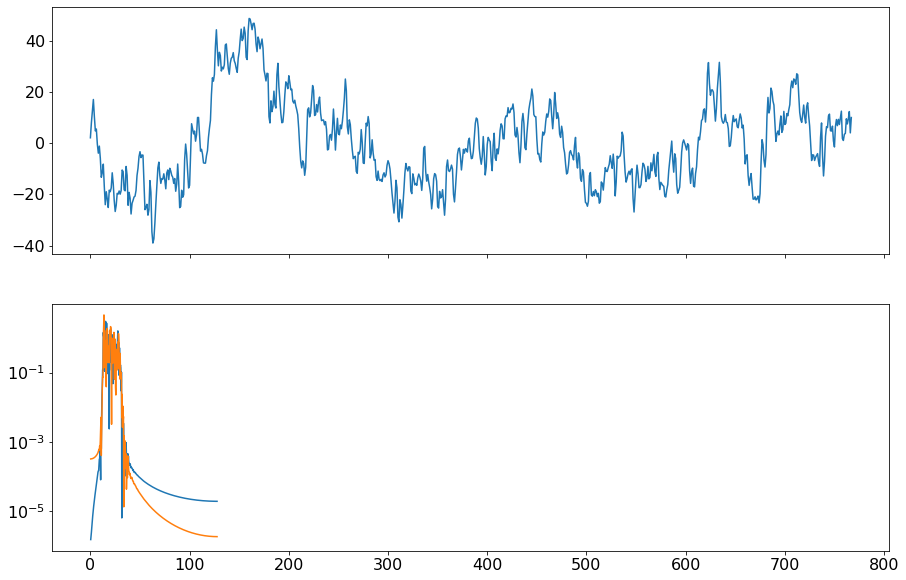

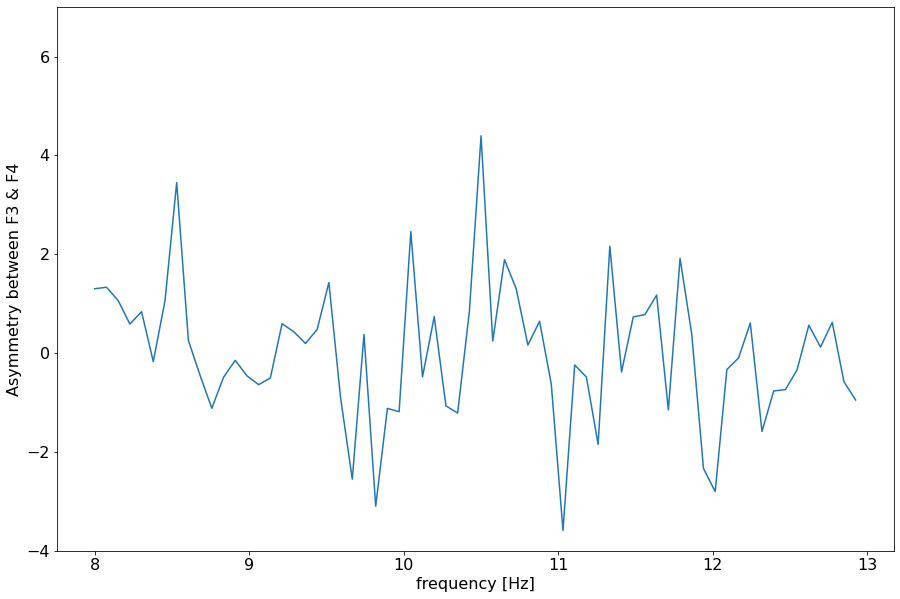

In [116]:
"""
t = np.linspace(0, 1, 256, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
"""
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sig = total_mean_neu[:,4]
sig_2 = total_mean_neu[:,39]
ax1.plot(sig)
#filtrated with bandpass filter at 3–30 Hz. EEG signal
f_s=256
sos = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')
filtered_f3 = signal.sosfilt(sos, sig)
filtered_f4 = signal.sosfilt(sos, sig_2)
#ax2.plot(filtered)
#ax2.set_title('After 15 Hz high-pass filter')
#ax2.set_xlabel('Time [seconds]')
#plt.tight_layout()
#plt.show()



# EEG segments with amplitudes exceeding ±80 μV were removed. 
print(np.max(filtered_f4))
print(np.max(filtered_f3))

#The power spectrum (μV2/Hz) of all segments was calculated using the Fast Fourier transformation and averaged for each condition.
f, pxx_f3 = signal.periodogram(filtered_f3, f_s)
plt.semilogy(f[1:-1], pxx_f3[1:-1])

f, pxx_f4 = signal.periodogram(filtered_f4, f_s)
plt.semilogy(f[1:-1], pxx_f4[1:-1])

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = pxx_f3[start:stop]
sub_f4 = pxx_f4[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
plt.ylim(-4,7)
plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")

plt.savefig("asymmetry_neutral")

In [120]:
len(pxx_f4)

385

8.00164082373274
9.253129855545161
[24]
[90]


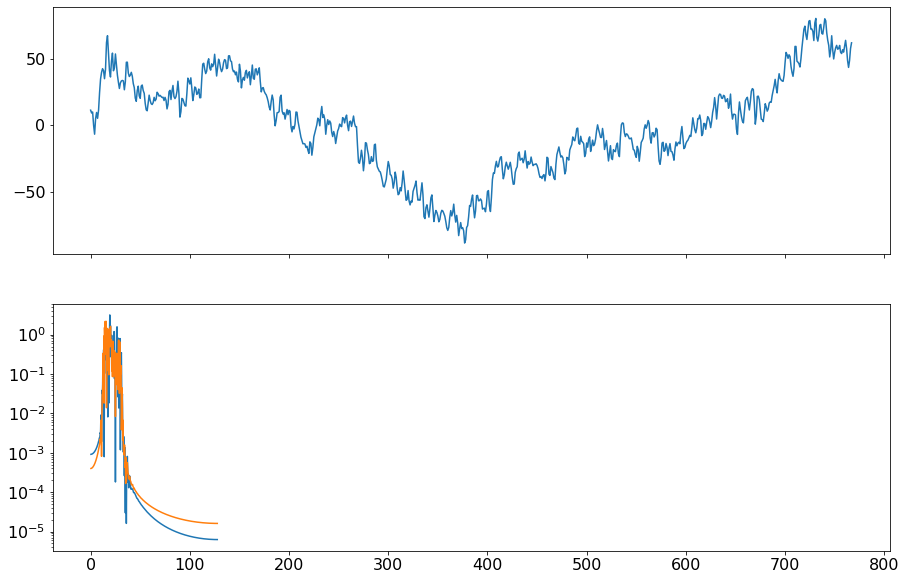

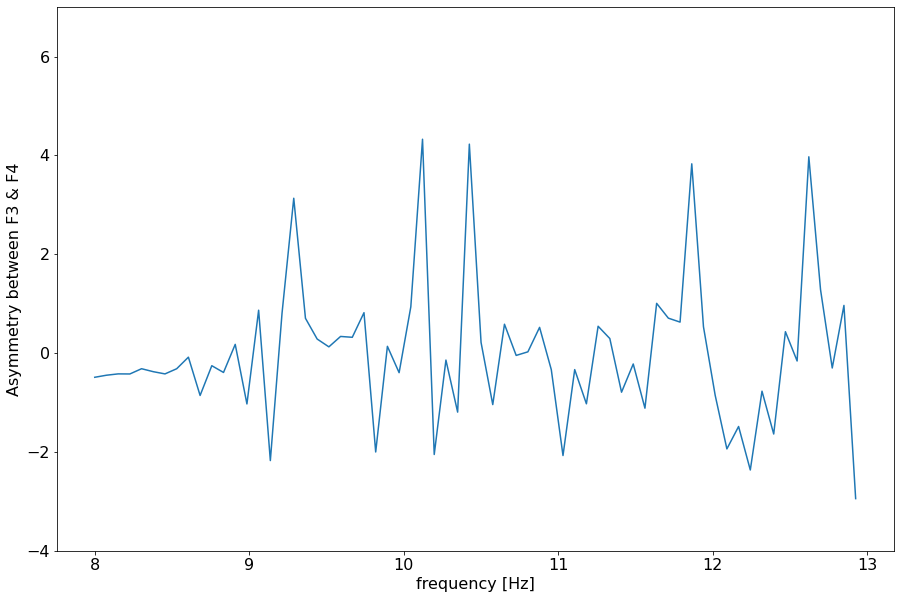

In [115]:
"""
t = np.linspace(0, 1, 256, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
"""
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sig = total_mean_dis[:,4]
sig_2 = total_mean_dis[:,39]
ax1.plot(sig)
#filtrated with bandpass filter at 3–30 Hz. EEG signal
f_s=256
sos = signal.butter(10, [13,30], 'band', fs=f_s, output='sos')
filtered_f3 = signal.sosfilt(sos, sig)
filtered_f4 = signal.sosfilt(sos, sig_2)
#ax2.plot(filtered)
#ax2.set_title('After 15 Hz high-pass filter')
#ax2.set_xlabel('Time [seconds]')
#plt.tight_layout()
#plt.show()



# EEG segments with amplitudes exceeding ±80 μV were removed. 
print(np.max(filtered_f4))
print(np.max(filtered_f3))

#The power spectrum (μV2/Hz) of all segments was calculated using the Fast Fourier transformation and averaged for each condition.
f, pxx_f3 = signal.periodogram(filtered_f3, f_s)
plt.semilogy(f[1:-1], pxx_f3[1:-1])

f, pxx_f4 = signal.periodogram(filtered_f4, f_s)
plt.semilogy(f[1:-1], pxx_f4[1:-1])

#Spectral power (μV2) at the alpha range (8–13 Hz) was exported
print(np.where(f==8)[0])
start = int(np.where(f==8)[0])
print(np.where(f==30)[0])
stop = int(np.where(f==30)[0])

sub_f3 = pxx_f3[start:stop]
sub_f4 = pxx_f4[start:stop]

# Finally, alpha power of EEG electrodes F3 and F4 was log-transformed and the asymmetry score 
#of frontal alpha was calculated by subtracting the value at F3 from the value at F4
plt.rcParams["figure.figsize"] = (15,10)
plt.figure(5)
plt.plot(np.arange(8,13,5/66),np.log(sub_f4)-np.log(sub_f3))
plt.ylim(-4,7)
plt.xlabel("frequency [Hz]")
plt.ylabel("Asymmetry between F3 & F4")
plt.savefig("asymmetry_dis")